In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg 
import scipy.linalg.interpolative as sli

plt.rcParams['figure.figsize'] = [5,5]

In [2]:
n = 1000
x = np.linspace(-1, 1, n)
eps = 0.1

In [3]:
def fun(x, y):
    """Evaluate a kernel function on a tensor grid"""
    xx = x.reshape(n,1)
    yy = y.reshape(1,n)
    return 1./(eps + np.abs(xx-yy))

In [4]:
A = fun(x, x)

In [38]:
nboxes = 20
size = n//nboxes

In [39]:
def get_box(nx, ny, mat, nboxes, n):
    """Return the content of a given box"""
    size = n//nboxes
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return mat[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

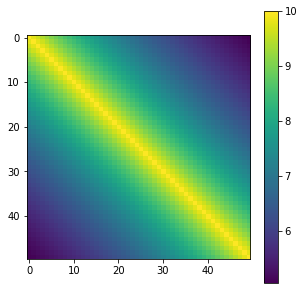

In [42]:
m1 = get_box(0, 0, A, nboxes,n)
plt.imshow(m1)
plt.colorbar()

In [43]:
def plot_singular_values(nx, ny, mat, nboxes, n):
    """Plot singular values of a given box."""
    from scipy.linalg import svdvals
    s = svdvals(get_box(nx, ny, mat, nboxes, n))
    plt.semilogy(s)
    plt.xlabel('k')
    plt.ylabel('sigma_k')

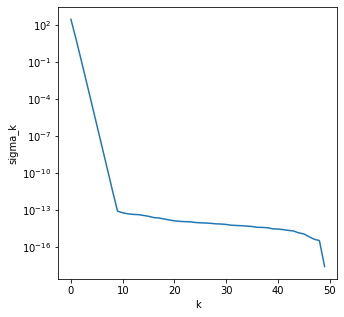

In [46]:
plot_singular_values(0,1,A,nboxes,n)

In [12]:
def plot_box_ranks(mat, nboxes, n, tol=1E-8):
    """Plot rank of the boxes."""
    from scipy.linalg import svdvals
    size = n // nboxes
    ranks = np.zeros((nboxes,nboxes),dtype='int32')
    for i in range(nboxes):
        for j in range(nboxes):
            m = get_box(i, j, mat, nboxes, n)
            s = svdvals(m)
            ranks[i,j] = np.sum(s>tol)
    plt.imshow(ranks, cmap='Accent')
    plt.colorbar()

In [13]:
def get_con_box(i,A,nboxes,n):
    """Return Ai"""
    BB = A[i * size : (i + 1) * size, :]
    B = np.delete(BB, np.s_[i*size : (i+1)*size], axis = 1)
    
    CC = np.transpose(A[:, i * size : (i + 1) * size])
    C = np.delete(CC, np.s_[i*size : (i+1)*size], axis = 1)
    return np.hstack((B,C))

In [14]:
def L(i,k,A,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box(i,A,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box(i,A,nboxes,n),k,idx1)
    B1_trans = np.transpose(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, k, rand = False)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.transpose(P2_trans)
    return P2,idx2

In [15]:
def index_set(k,A,nboxes,n):
    l = []
    for i in range(nboxes):
        l.append(L(i,k,A,nboxes,n)[1][0:k])
    return l

In [16]:
def SSS(k,A,nboxes,n):
    ll = index_set(k,A,nboxes,n)
    mat = np.zeros((k*nboxes,k*nboxes))
    for i in range(nboxes):
        for j in range(nboxes):
            if i != j:
                mat_ =  get_box(i,j,A,nboxes,n)[ll[i],:]
                mat[i*k:(i+1)*k,j*k:(j+1)*k] = mat_[:,ll[j]]
    return mat

In [17]:
def R(i,k,A,nboxes,n):
    RR = np.transpose(L(i,k,A,nboxes,n)[0])
    return RR

In [18]:
def new_S(k,A,nboxes,n):
    mat_ = SSS(k,A,nboxes,n)
    for i in range(nboxes):
        mat_[i*k:(i+1)*k,i*k:(i+1)*k] = np.linalg.inv(R(i,k,A,nboxes,n) @ np.linalg.inv(get_box(i,i,A,nboxes,n)) @ L(i,k,A,nboxes,n)[0])
    return mat_

In [19]:
def D_(k,A,nboxes,n):
    mat = np.zeros((n,n))
    for i in range(nboxes):
        mat[i*size:(i+1)*size,i*size:(i+1)*size] = np.linalg.inv(get_box(i,i,A,nboxes,n)) - \
        np.linalg.inv(get_box(i,i,A,nboxes,n))@L(i,k,A,nboxes,n)[0]@np.linalg.inv(R(i,k,A,nboxes,n) @ np.linalg.inv(get_box(i,i,A,nboxes,n)) @ L(i,k,A,nboxes,n)[0])@ \
        R(i,k,A,nboxes,n)@np.linalg.inv(get_box(i,i,A,nboxes,n))
        
    return mat

In [20]:
def L_(k,A,nboxes,n):
    mat = np.zeros((n,k*nboxes))
    for i in range(nboxes):
        mat[i*size:(i+1)*size,i*k:(i+1)*k] = np.linalg.inv(get_box(i,i,A,nboxes,n))@L(i,k,A,nboxes,n)[0]@np.linalg.inv(R(i,k,A,nboxes,n) @ np.linalg.inv(get_box(i,i,A,nboxes,n)) @ L(i,k,A,nboxes,n)[0])
    return mat

In [21]:
def R_(k,A,nboxes,n):
    mat = np.zeros((k*nboxes,n))
    for i in range(nboxes):
        mat[i*k:(i+1)*k,i*size:(i+1)*size] = np.linalg.inv(R(i,k,A,nboxes,n) @ np.linalg.inv(get_box(i,i,A,nboxes,n)) @ L(i,k,A,nboxes,n)[0])@ \
        R(i,k,A,nboxes,n)@np.linalg.inv(get_box(i,i,A,nboxes,n))
    return mat

In [22]:
def S_(k,A,nboxes,n):
    mat = SSS(k,A,nboxes,n)
    for i in range(nboxes):
         mat[i*k:(i+1)*k,i*k:(i+1)*k] = np.linalg.inv(R(i,k,A,nboxes,n) @ np.linalg.inv(get_box(i,i,A,nboxes,n)) @ L(i,k,A,nboxes,n)[0])
    return mat

In [33]:
def inv_(k,A,nboxes,n):
    return D_(k,A,nboxes,n) + L_(k,A,nboxes,n) @ np.linalg.inv(S_(k,A,nboxes,n)) @ R_(k,A,nboxes,n)

In [24]:
b = np.random.rand(n)

In [25]:
x_exact = np.linalg.solve(A,b)

In [29]:
error_list = []
for i in range(1,size+1):
    x_appro = inv_(i,A,nboxes,n) @ b
    error_list.append(np.linalg.norm(x_exact - x_appro)/np.linalg.norm(x_exact))

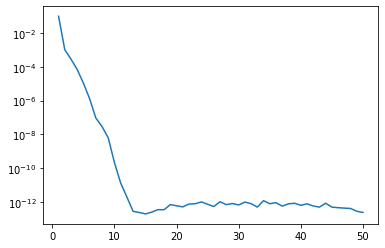

In [30]:
plt.semilogy(range(1,size+1), error_list)